In [5]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

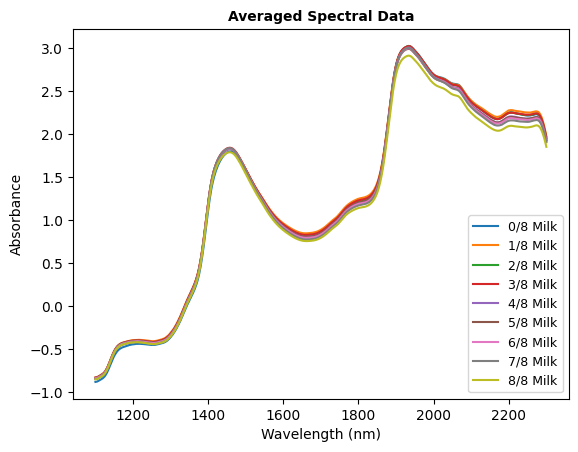

In [6]:
# DATASET
path = 'dataset/clf_milk.csv'
data = pd.read_csv(path)
# --- Labels
label = data.values[:,0].astype('uint8')
#print(label)
# --- Spectral data; transform from reflectance to absorbance
target_names = {
    1: '0/8 Milk',
    2: '1/8 Milk',
    3: '2/8 Milk',
    4: '3/8 Milk',
    5: '4/8 Milk',
    6: '5/8 Milk',
    7: '6/8 Milk',
    8: '7/8 Milk',
    9: '8/8 Milk'
}
spectra_raw = np.log(1.0/(data.values[:,1:]).astype('float32'))

# Scale the features/spectral data
#scaled_raw_sectra = StandardScaler().fit_transform(spectra_raw)
#scaled_sg_spectra = StandardScaler().fit_transform(spectra_sg)

# --- Wavelengths
wls = np.arange(1100,2302,2)

l1 = data.values[0:50,1].astype('uint8')
l2 = data.values[50:100,1].astype('uint8')
l3 = data.values[100:150,1].astype('uint8')
l4 = data.values[150:200,1].astype('uint8')
l5 = data.values[200:250,1].astype('uint8')
l6 = data.values[250:300,1].astype('uint8')
l7 = data.values[300:350,1].astype('uint8')
l8 = data.values[350:400,1].astype('uint8')
l9 = data.values[400:450,1].astype('uint8')

s1 = np.log(1.0/(data.values[0:50,1:]).astype('float32'))
s2 = np.log(1.0/(data.values[50:100,1:]).astype('float32'))
s3 = np.log(1.0/(data.values[100:150,1:]).astype('float32'))
s4 = np.log(1.0/(data.values[150:200,1:]).astype('float32'))
s5 = np.log(1.0/(data.values[200:250,1:]).astype('float32'))
s6 = np.log(1.0/(data.values[250:300,1:]).astype('float32'))
s7 = np.log(1.0/(data.values[300:350,1:]).astype('float32'))
s8 = np.log(1.0/(data.values[350:400,1:]).astype('float32'))
s9 = np.log(1.0/(data.values[400:450,1:]).astype('float32'))

mean_s1 = np.mean(s1[:,:], axis=0)
mean_s2 = np.mean(s2[:,:], axis=0)
mean_s3 = np.mean(s3[:,:], axis=0)
mean_s4 = np.mean(s4[:,:], axis=0)
mean_s5 = np.mean(s5[:,:], axis=0)
mean_s6 = np.mean(s6[:,:], axis=0)
mean_s7 = np.mean(s7[:,:], axis=0)
mean_s8 = np.mean(s8[:,:], axis=0)
mean_s9 = np.mean(s9[:,:], axis=0)

plt.plot(wls, mean_s1.T, label="0/8 Milk")
plt.plot(wls, mean_s2.T, label="1/8 Milk")
plt.plot(wls, mean_s3.T, label="2/8 Milk")
plt.plot(wls, mean_s4.T, label="3/8 Milk")
plt.plot(wls, mean_s5.T, label="4/8 Milk")
plt.plot(wls, mean_s6.T, label="5/8 Milk")
plt.plot(wls, mean_s7.T, label="6/8 Milk")
plt.plot(wls, mean_s8.T, label="7/8 Milk")
plt.plot(wls, mean_s9.T, label="8/8 Milk")

plt.xlabel("Wavelength (nm)", fontsize=10)
plt.ylabel("Absorbance", fontsize=10)
plt.title('Averaged Spectral Data', fontweight='bold', fontsize=10)
plt.legend(prop={'size': 9},loc=4)  #loc='lower right'
plt.show()


In [7]:
# SIMPLE MOVING AVERAGE
def sma(input_spectra, window_size):
    df = pd.DataFrame(input_spectra)
    moving_averages = df.rolling(window_size).mean()
    return moving_averages

# MSC - MULTIPLICATIVE SCATTER CORRECTION
def msc(input_spectra, reference=None):
    # --- Mean center correction
    for i in range(input_spectra.shape[0]):
        input_spectra[i,:] -= input_spectra[i,:].mean()
    # --- Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # --- Calculate mean
        ref = np.mean(input_spectra, axis=0)
    else:
        ref = reference
    # --- Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Run regression
        fit = np.polyfit(ref, input_spectra[i,:], 1, full=True)
        # --- Apply correction
        data_msc[i,:] = (input_spectra[i,:] - fit[0][1]) / fit[0][0]
    return data_msc, ref

# STANDARD NORMAL VARIATE
def snv(input_spectra):
    # --- Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # --- Apply correction
        output_data[i,:] = (input_spectra[i,:] - np.mean(input_spectra[i,:])) / np.std(input_spectra[i,:])
    return output_data

# SAVITZKY-GOLAY SMOOTHING
def SG_smoothing(input_data, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    return SG_smoothing

# SAVITZKY-GOLAY DERIVATIVE/FILTER
def SG_derivative(input_data, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    return SG_filter

# --- Preprocessed spectra
spectra_sma = sma(spectra_raw, window_size=7)
spectra_msc = msc(spectra_raw, reference=None)
spectra_sgd = SG_derivative(spectra_raw, window_size=24, polyorder=5, derivative=2)


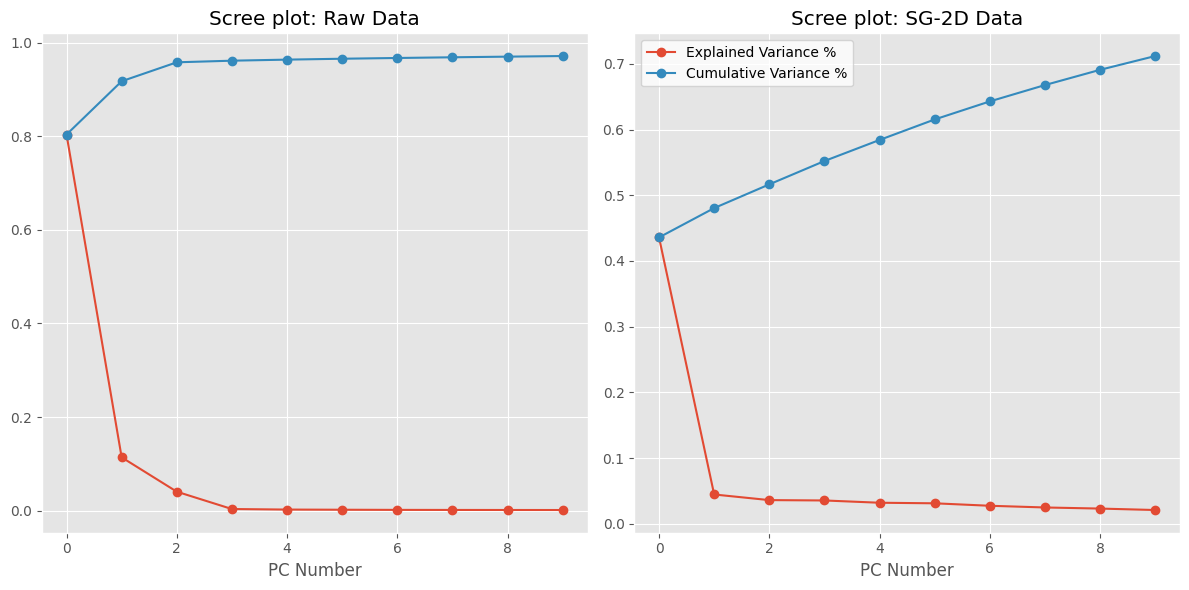

Explained variation per principal component: 80.36%
Explained variation per principal component: 11.39%
Explained variation per principal component: 4.05%
Explained variation per principal component: 0.34%
Explained variation per principal component: 0.23%
Explained variation per principal component: 0.19%
Explained variation per principal component: 0.16%
Explained variation per principal component: 0.15%
Explained variation per principal component: 0.14%
Explained variation per principal component: 0.13%


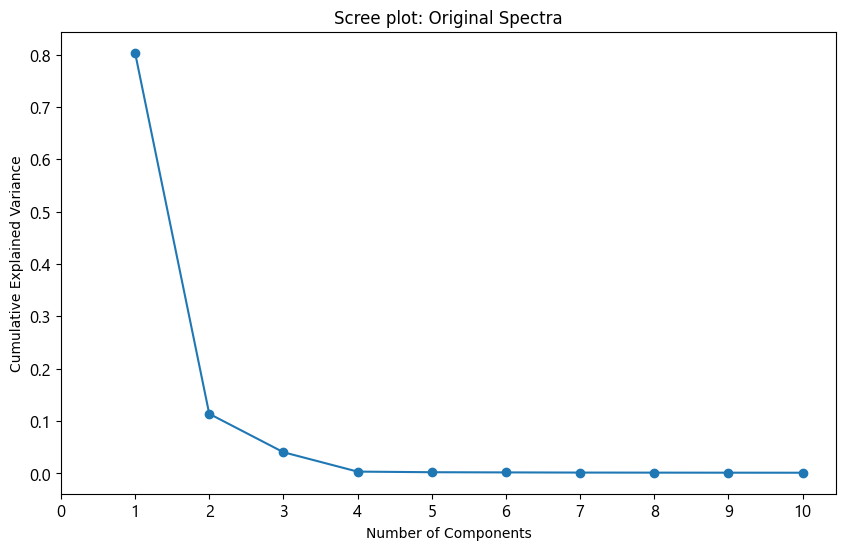

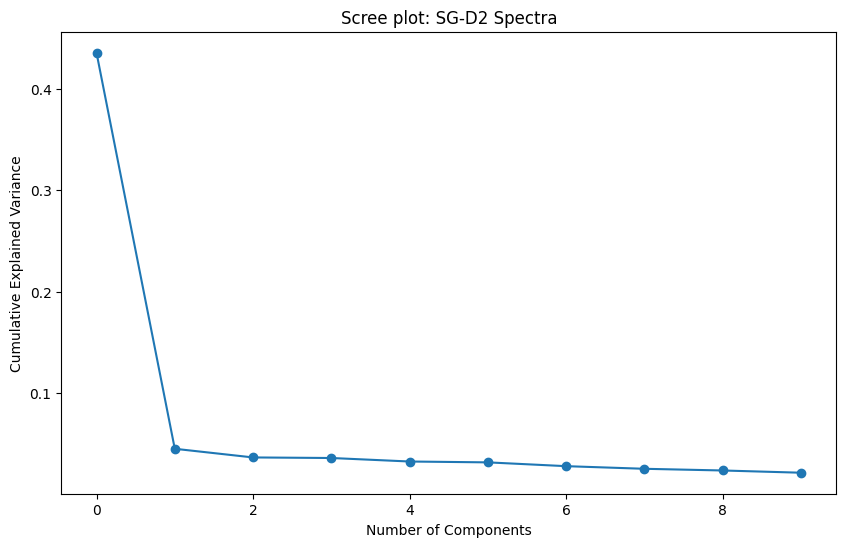

In [16]:
# NUMBER OF PRINCIPLE COMPONENTS

pca = PCA(n_components=10)
# Fit the spectral data and extract the explained variance ratio
X1 = pca.fit(spectra_raw)
expl_var_1 = X1.explained_variance_ratio_

X2 = pca.fit(spectra_sgd)
expl_var_2 = X2.explained_variance_ratio_


# PLOT DATA
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.set_tight_layout(True)

    ax1.plot(expl_var_1, '-o', label='Explained Variance %')
    ax1.plot(np.cumsum(expl_var_1), '-o', label = 'Cumulative Variance %')
    ax1.set_xlabel('PC Number')
    ax1.set_title('Scree plot: Raw Data')

    ax2.plot(expl_var_2, '-o', label='Explained Variance %')
    ax2.plot(np.cumsum(expl_var_2), '-o', label = 'Cumulative Variance %')
    ax2.set_xlabel('PC Number')
    ax2.set_title('Scree plot: SG-2D Data')
plt.legend()
plt.show()

# SCREE PLOT
x = np.arange(1, 11)
for v in expl_var_1:
    print('Explained variation per principal component: {}%'.format(round(v*100,2)))

plt.subplots(figsize=(10,6))
plt.plot(x, expl_var_1, '-o')
#for index in range(len(x)):
#  ax.text(x[index], percentage_total_var_explained[index], percentage_total_var_explained[index], size=10)
plt.title('Scree plot: Original Spectra')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 11, step=1), fontsize=12, fontname="Segoe UI")
plt.yticks(fontsize=12, fontname="Segoe UI")
plt.show()

# SCREE PLOT
plt.subplots(figsize=(10,6))
plt.plot(expl_var_2, '-o')
plt.title('Scree plot: SG-D2 Spectra')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

        PC1       PC2       PC3       PC4
0 -0.689634 -0.700481 -0.689451 -0.665283
1 -0.059622 -0.097934 -0.045502 -0.067575
2  0.177549  0.161839  0.164402  0.171538
3  0.009139 -0.020024 -0.007663 -0.005160


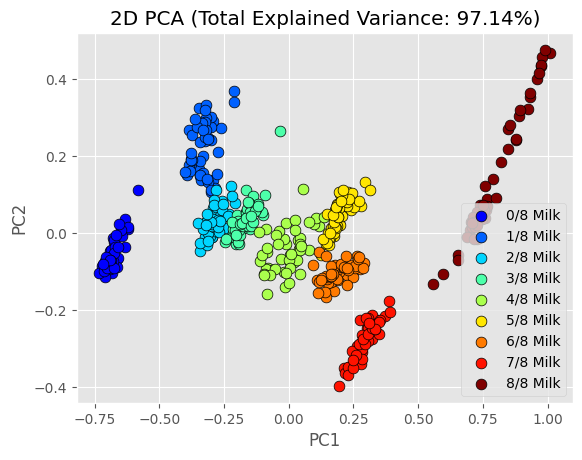

In [24]:
# PCA SCATTER PLOT
def pc_scores(input_spectra, num_comps, explained_variance):
    pca1 = PCA(n_components=num_comps)
    # Transform on the scaled features
    Xcomps = pca1.fit_transform(input_spectra)
    pc_list = ['PC'+ str(i) for i in list(range(1, num_comps+1))]
    scores_df =pd.DataFrame.from_dict(dict(zip(pc_list, Xcomps)))
    print(scores_df)

    # Define the labels
    label_name = ['0/8 Milk', '1/8 Milk', '2/8 Milk', '3/8 Milk', '4/8 Milk', '5/8 Milk', '6/8 Milk', '7/8 Milk', '8/8 Milk']

    PCs_var = explained_variance*100
    total_var = explained_variance.sum()*100

    # 2D Scatter Plot
    unique = list(set(label))
    colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
    with plt.style.context(('ggplot')):
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            pc1 = [Xcomps[j,0] for j in range(len(Xcomps[:,0])) if label[j] == u]    # PC1
            pc2 = [Xcomps[j,1] for j in range(len(Xcomps[:,1])) if label[j] == u]    # PC2
            pc3 = [Xcomps[j,2] for j in range(len(Xcomps[:,2])) if label[j] == u]    # PC3
            pc4 = [Xcomps[j,3] for j in range(len(Xcomps[:,3])) if label[j] == u]    # PC4
            plt.scatter(pc1, pc2, c=col, s=60, edgecolors='k', label=str(u))
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend(label_name, loc = 'lower right')
        plt.title('2D PCA' + f' (Total Explained Variance: {total_var:.2f}%)')
        plt.show()

    # 2D PCA Scatter Plot
    fig = px.scatter(Xcomps, x=0, y=1, color=label,
                     labels={'0':'PC1 ('+str(round(PCs_var[0],2))+'%)',
                             '1':'PC2 ('+str(round(PCs_var[1],2))+'%)'})
    fig.update_layout(
        autosize=False, width=600, height=500,
        margin=dict(l=50, r=50, b=50, t=50, pad=4),
        paper_bgcolor="white",
    )
    fig.show()

    # 3D PCA Plot

    fig = px.scatter_3d(Xcomps, x=0, y=1, z=2, color=label,
                        title=f'Total Explained Variance: {total_var:.2f}%',
                        labels={'0':'PC1 ('+str(round(PCs_var[0],2))+'%)',
                                '1':'PC2 ('+str(round(PCs_var[1],2))+'%)',
                                '2':'PC3 ('+str(round(PCs_var[2],2))+'%)'})

    fig.update_layout(
        autosize=False, width=700, height=500,
        margin=dict(l=50, r=50, b=50, t=50, pad=4),
        paper_bgcolor='white',
    )
    fig.show()
pcs = pc_scores(spectra_raw, 4, expl_var_1)

          PC1       PC2       PC3       PC4
0    0.057320  0.013320  0.017039 -0.062918
1    0.057603  0.013337  0.018065 -0.063050
2    0.057472  0.013033  0.018107 -0.059762
3    0.057292  0.013625  0.017031 -0.058378
4    0.057032  0.013662  0.017247 -0.059685
..        ...       ...       ...       ...
596 -0.037725  0.021449 -0.051599 -0.040052
597 -0.033754  0.019260 -0.049177 -0.030609
598 -0.030358  0.018758 -0.046840 -0.027903
599 -0.025745  0.018036 -0.046480 -0.024147
600 -0.022080  0.016381 -0.045484 -0.023297

[601 rows x 4 columns]


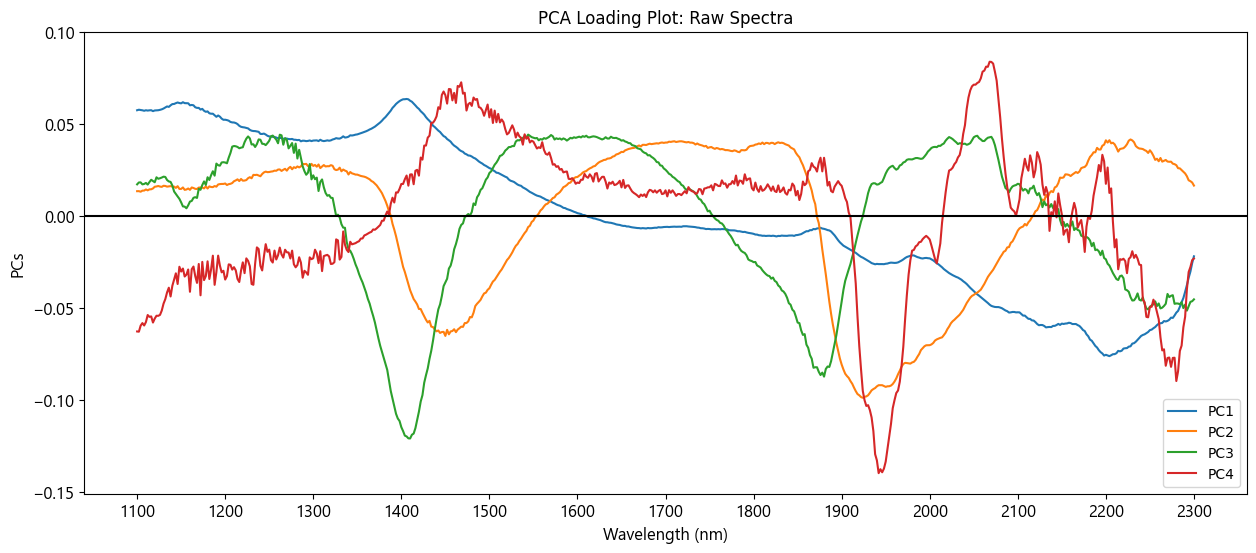

In [28]:
# LOADING PLOTS
def loadings(input_spectra, num_comps):
    pca = PCA(n_components=num_comps)
    components = pca.fit_transform(input_spectra)

    # --- Principal components correlation coefficients
    loadings = pca.components_

    #loadings = pca.components_
    num_pcs = pca.n_features_in_

    pc_list = ['PC'+ str(i) for i in list(range(1, num_pcs+1))]
    loadings_df =pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
    print(loadings_df)


    # PLOT DATA
    plt.style.context(('ggplot'))
    plt.figure(figsize=(15, 6))
    plt.plot(wls, loadings_df['PC1'], label='PC1')
    plt.plot(wls, loadings_df['PC2'], label='PC2')
    plt.plot(wls, loadings_df['PC3'], label='PC3')
    plt.plot(wls, loadings_df['PC4'], label='PC4')
    plt.title('PCA Loading Plot: Raw Spectra')
    plt.xticks(np.arange(1100, 2400, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(np.arange(-0.15, 0.15, step=0.05), fontsize=12, fontname="Segoe UI")
    plt.ylabel('PCs', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.axhline(y=0.0, color='black', linestyle='-')
    plt.legend(loc = 'lower right')
    plt.show()

pc_loading = loadings(spectra_raw, 4)

C:\Users\Asus\AppData\Local\Temp\ipykernel_18408\803766521.py:6: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



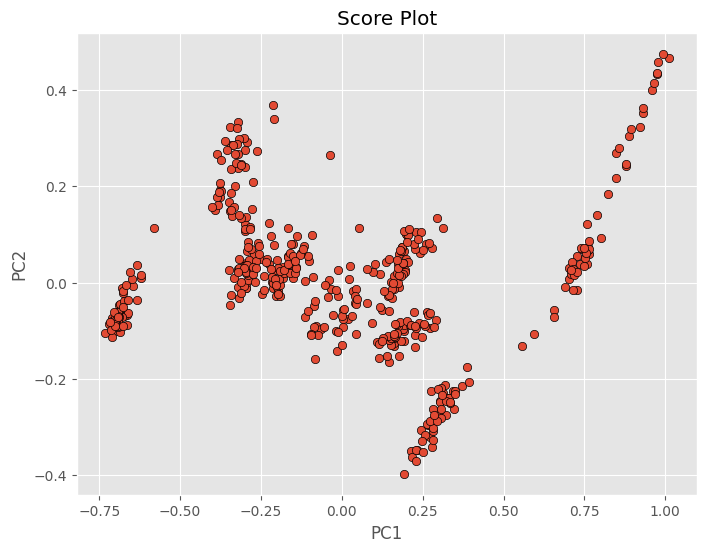

C:\Users\Asus\AppData\Local\Temp\ipykernel_18408\803766521.py:15: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



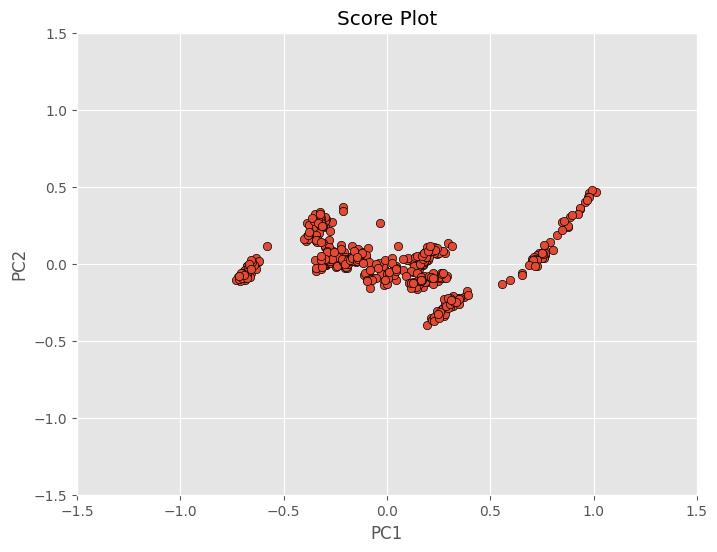

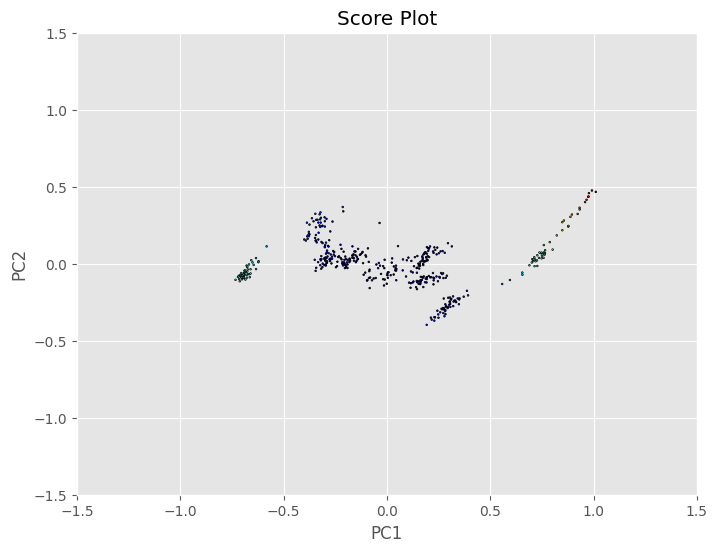

In [35]:
# OUTLIERS DETECTION
pca = PCA()
T = pca.fit_transform(spectra_raw)
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:,0], T[:,1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

# Euclidean distance for score plots
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:,0], T[:,1], edgecolors='k', cmap='jet')
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

# Compute the euclidean distance using the first 5 PCs
euclidean = np.zeros(spectra_raw.shape[0])
for i in range(5):
    euclidean += (T[:,i] - np.mean(T[:,:5])) ** 2/np.var(T[:,:5])
colors = [plt.cm.jet(float(i)/max(euclidean)) for i in euclidean]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:,0], T[:,1], c=colors, edgecolors='k', s=1.5)
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

from sklearn.covariance import EmpiricalCovariance, MinCovDet
# Fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(T[:,:5])
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:5])

In [36]:
# Hoteling Tsquare
pca1 = pca.fit_transform(spectra_raw)

loadings_p = pca.components_.T
eivenvalues = pca.explained_variance_

hotelling_t2s = np.array([xi.dot(loadings_p).dot(np.diag(eivenvalues ** -1)).dot(loadings_p.T).dot(xi.T) for xi in spectra_raw])


In [37]:
# Computing the PCA from scratch involves various steps, including:
# (1) standardization of the input dataset (optional step),
X = spectra_raw
X = pd.DataFrame(X)
#print(scaled_X.head(5))

# (2) calculating mean adjusted matrix,
adjusted_X = X - X.mean()
#print(adjusted_X.head(5))

# (3) calculating covariance matrix,
covmat_X = adjusted_X.cov()
#print(covmat_X.head(5))

# (4) calculating eigenvectors and eigenvalues.
from numpy.linalg import eig
eivenvalues, eigenvectors = eig(adjusted_X.cov())
#print(eivenvalues)
# we are interested in the highest eigenvalues as it explains most of the variance this helps to reduce the dimensions

#print(eigenvectors)
# column eigenvectors[:,i] is the eigenvectors of eigenvalues[i]

In [ ]:
# References:
# https://blog.4dcu.be/programming/2021/03/19/Code-Nugget-PCA-with-loadings.html
# https://nirpyresearch.com/classification-nir-spectra-principal-component-analysis-python/
# https://www.reneshbedre.com/blog/principal-component-analysis.html#pca-from-scratch

# https://github.com/erdogant/pca/blob/master/notebooks/pca_examples.ipynb
# https://github.com/ChristianGoueguel/HotellingEllipse
